# Analyzing Key Supply-Demand Factors Affecting U.S. Home Prices

The data contains supply-demand factors that influence US home prices from past 20 years. This data are categorized into two datasets: Supply and Demand. 

#### Supply Data:
- DATE: The date of the observation. (2003 - 2023)
- PERMIT: New Privately-Owned Housing Units Authorized in Permit-Issuing Places: Total Units (Thousands of Units, Seasonally Adjusted Annual Rate). This variable represents the number of new housing units authorized for construction in permit-issuing places.
- MSACSR: Monthly Supply of New Houses in the United States (Seasonally Adjusted). It indicates the monthly supply of new houses available in the United States.
- TLRESCONS: Total Construction Spending: Residential in the United States (Millions of Dollars, Seasonally Adjusted Annual Rate). This variable represents the total construction spending on residential projects.
- EVACANTUSQ176N: Housing Inventory Estimate: Vacant Housing Units in the United States (Thousands of Units, Not Seasonally Adjusted). It provides an estimate of the number of vacant housing units in the United States.
- CSUSHPISA: S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted). This variable serves as a proxy for home prices and represents the home price index for the United States.


#### Demand Data:
- INTDSRUSM193N: Interest Rates, Discount Rate for United States (Billions of Dollars, Seasonally Adjusted Annual Rate). This variable represents the interest rates or discount rates for the United States.
- UMCSENT: University of Michigan: Consumer Sentiment. It measures the consumer sentiment index based on surveys conducted by the University of Michigan.
- GDP: Gross Domestic Product (Billions of Dollars, Seasonally Adjusted Annual Rate).
- MORTGAGE15US: 30-Year Fixed Rate Mortgage Average in the United States (Percent, Not Seasonally Adjusted). It indicates the average interest rate for a 30-year fixed-rate mortgage.
- MSPUS: Median Sales Price of Houses Sold for the United States (Not Seasonally Adjusted)
- CSUSHPISA: S&P/Case-Shiller U.S. National Home Price Index (Index Jan 2000=100, Seasonally Adjusted). This variable serves as a proxy for home prices and represents the home price index for the United States.

#### Dependent variable:
The S&P Case-Shiller U.S. National Home Price Index (CSUSHPISA) is used as a proxy for home prices and serves as the dependent variable in the analysis.

In [1]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importing libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

In [4]:
# Importing data

supply_data = pd.read_csv("supply.csv")
demand_data = pd.read_csv("demand.csv")

In [5]:
# Checking data

supply_data.head()

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895


In [6]:
demand_data.head()

,DATE,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,01-01-2003,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,01-04-2003,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,01-07-2003,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,01-10-2003,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,01-01-2004,143.298667,5.597500,98.000000,2.000000,212700,11923.447


#### Inspecting various aspects of the datasets

In [7]:
# Shape of the datasets

print(supply_data.shape, demand_data.shape)

(82, 6) (81, 7)


In [8]:
# Checking data columns

print(supply_data.info(), demand_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   DATE            82 non-null     object
 1   CSUSHPISA       82 non-null     object
 2   MSACSR          82 non-null     object
 3   PERMIT          82 non-null     object
 4   TLRESCONS       82 non-null     object
 5   EVACANTUSQ176N  82 non-null     object
dtypes: object(6)
memory usage: 4.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DATE           81 non-null     object 
 1   CSUSHPISA      80 non-null     float64
 2   MORTGAGE30US   81 non-null     float64
 3   UMCSENT        81 non-null     float64
 4   INTDSRUSM193N  74 non-null     float64
 5   MSPUS          81 non-null     int64  
 6   GDP            81 non-null     float64
dtypes: 

In [9]:
# Changing the data types for date column and other columns in supply data

supply_data["DATE"] = pd.to_datetime(supply_data["DATE"])
demand_data["DATE"] = pd.to_datetime(demand_data["DATE"])

In [10]:
# Changing object datatype to float in Supply_data

for i in supply_data.columns:
    if i != "DATE":
        supply_data[i] = pd.to_numeric(supply_data[i],errors='coerce')

In [11]:
supply_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   DATE            82 non-null     datetime64[ns]
 1   CSUSHPISA       80 non-null     float64       
 2   MSACSR          81 non-null     float64       
 3   PERMIT          81 non-null     float64       
 4   TLRESCONS       81 non-null     float64       
 5   EVACANTUSQ176N  81 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 4.0 KB


In [12]:
# Sorting data by Merging supply and demand data

supply_data = supply_data.sort_values('DATE')
demand_data = demand_data.sort_values('DATE')

merged_data = pd.merge(supply_data, demand_data, on='DATE', suffixes=('_supply', '_demand'))

In [13]:
# Checking missing values on merged data

merged_data.isnull().sum()

DATE                0
CSUSHPISA_supply    1
MSACSR              0
PERMIT              0
TLRESCONS           0
EVACANTUSQ176N      0
CSUSHPISA_demand    1
MORTGAGE30US        0
UMCSENT             0
INTDSRUSM193N       7
MSPUS               0
GDP                 0
dtype: int64

In [14]:
# Imputing missing values using mean for missing data

imputer = SimpleImputer(strategy='mean')
merged_data['INTDSRUSM193N'] = imputer.fit_transform(merged_data[['INTDSRUSM193N']])
merged_data['CSUSHPISA_supply'] = imputer.fit_transform(merged_data[['CSUSHPISA_supply']])
merged_data['CSUSHPISA_demand'] = imputer.fit_transform(merged_data[['CSUSHPISA_demand']])

In [15]:
merged_data.isnull().sum()

DATE                0
CSUSHPISA_supply    0
MSACSR              0
PERMIT              0
TLRESCONS           0
EVACANTUSQ176N      0
CSUSHPISA_demand    0
MORTGAGE30US        0
UMCSENT             0
INTDSRUSM193N       0
MSPUS               0
GDP                 0
dtype: int64

In [16]:
merged_data = merged_data.reset_index(drop=True)
merged_data.head()

,DATE,CSUSHPISA_supply,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,CSUSHPISA_demand,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
0,2003-01-01,129.321000,4.200000,1806.333333,421328.6667,14908.0,129.321000,5.840769,79.966667,2.250000,186000,11174.129
1,2003-01-04,131.756000,3.833333,1837.666667,429308.6667,15244.0,131.756000,5.506923,89.266667,2.166667,191800,11312.766
2,2003-01-07,135.013000,3.633333,1937.333333,458890.0000,15614.0,135.013000,6.033846,89.300000,2.000000,191900,11566.669
3,2003-01-10,138.835667,3.966667,1972.333333,491437.3333,15654.0,138.835667,5.919286,91.966667,2.000000,198800,11772.234
4,2004-01-01,143.298667,3.700000,1994.666667,506856.3333,15895.0,143.298667,5.597500,98.000000,2.000000,212700,11923.447


In [17]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   DATE              81 non-null     datetime64[ns]
 1   CSUSHPISA_supply  81 non-null     float64       
 2   MSACSR            81 non-null     float64       
 3   PERMIT            81 non-null     float64       
 4   TLRESCONS         81 non-null     float64       
 5   EVACANTUSQ176N    81 non-null     float64       
 6   CSUSHPISA_demand  81 non-null     float64       
 7   MORTGAGE30US      81 non-null     float64       
 8   UMCSENT           81 non-null     float64       
 9   INTDSRUSM193N     81 non-null     float64       
 10  MSPUS             81 non-null     int64         
 11  GDP               81 non-null     float64       
dtypes: datetime64[ns](1), float64(10), int64(1)
memory usage: 7.7 KB


In [18]:
# Dropping one of the duplicate Case shiller price column
merged_data.drop('CSUSHPISA_demand',1,inplace=True)

#renaming the column
merged_data.rename(columns={"CSUSHPISA_supply":"CSUSHPISA"},inplace=True)

In [19]:
# Checking the summary statistics of the data

merged_data.describe(percentiles=[0.25,0.5,0.75,0.9,0.95])

,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000
mean,180.658712,6.161317,1310.769547,494813.757199,17096.975309,4.705420,82.149794,1.961712,281104.938272,17298.487852
std,41.150871,1.921230,477.082533,180463.943450,1383.954497,1.114588,12.408088,1.655336,68121.518078,3851.890323
min,129.321000,3.400000,538.666667,246953.333300,13876.000000,2.760714,56.100000,0.250000,186000.000000,11174.129000
25%,148.209000,4.800000,988.333333,358938.666700,15883.000000,3.822308,73.866667,0.750000,228100.000000,14448.882000
50%,172.964333,5.566667,1282.333333,491437.333300,17268.000000,4.440000,82.966667,1.583333,258400.000000,16629.050000
75%,195.976333,7.533333,1697.000000,583015.333300,18219.000000,5.768462,93.066667,2.333333,318400.000000,19894.750000
90%,233.090000,9.166667,1994.666667,753515.666700,18843.000000,6.243846,97.200000,4.916667,369800.000000,22313.850000
95%,277.317000,9.833333,2105.000000,842559.666700,18998.000000,6.372308,98.133333,6.000000,433100.000000,24740.480000
max,303.422667,11.400000,2228.333333,947300.333300,19137.000000,6.664615,98.933333,6.250000,479500.000000,26465.865000


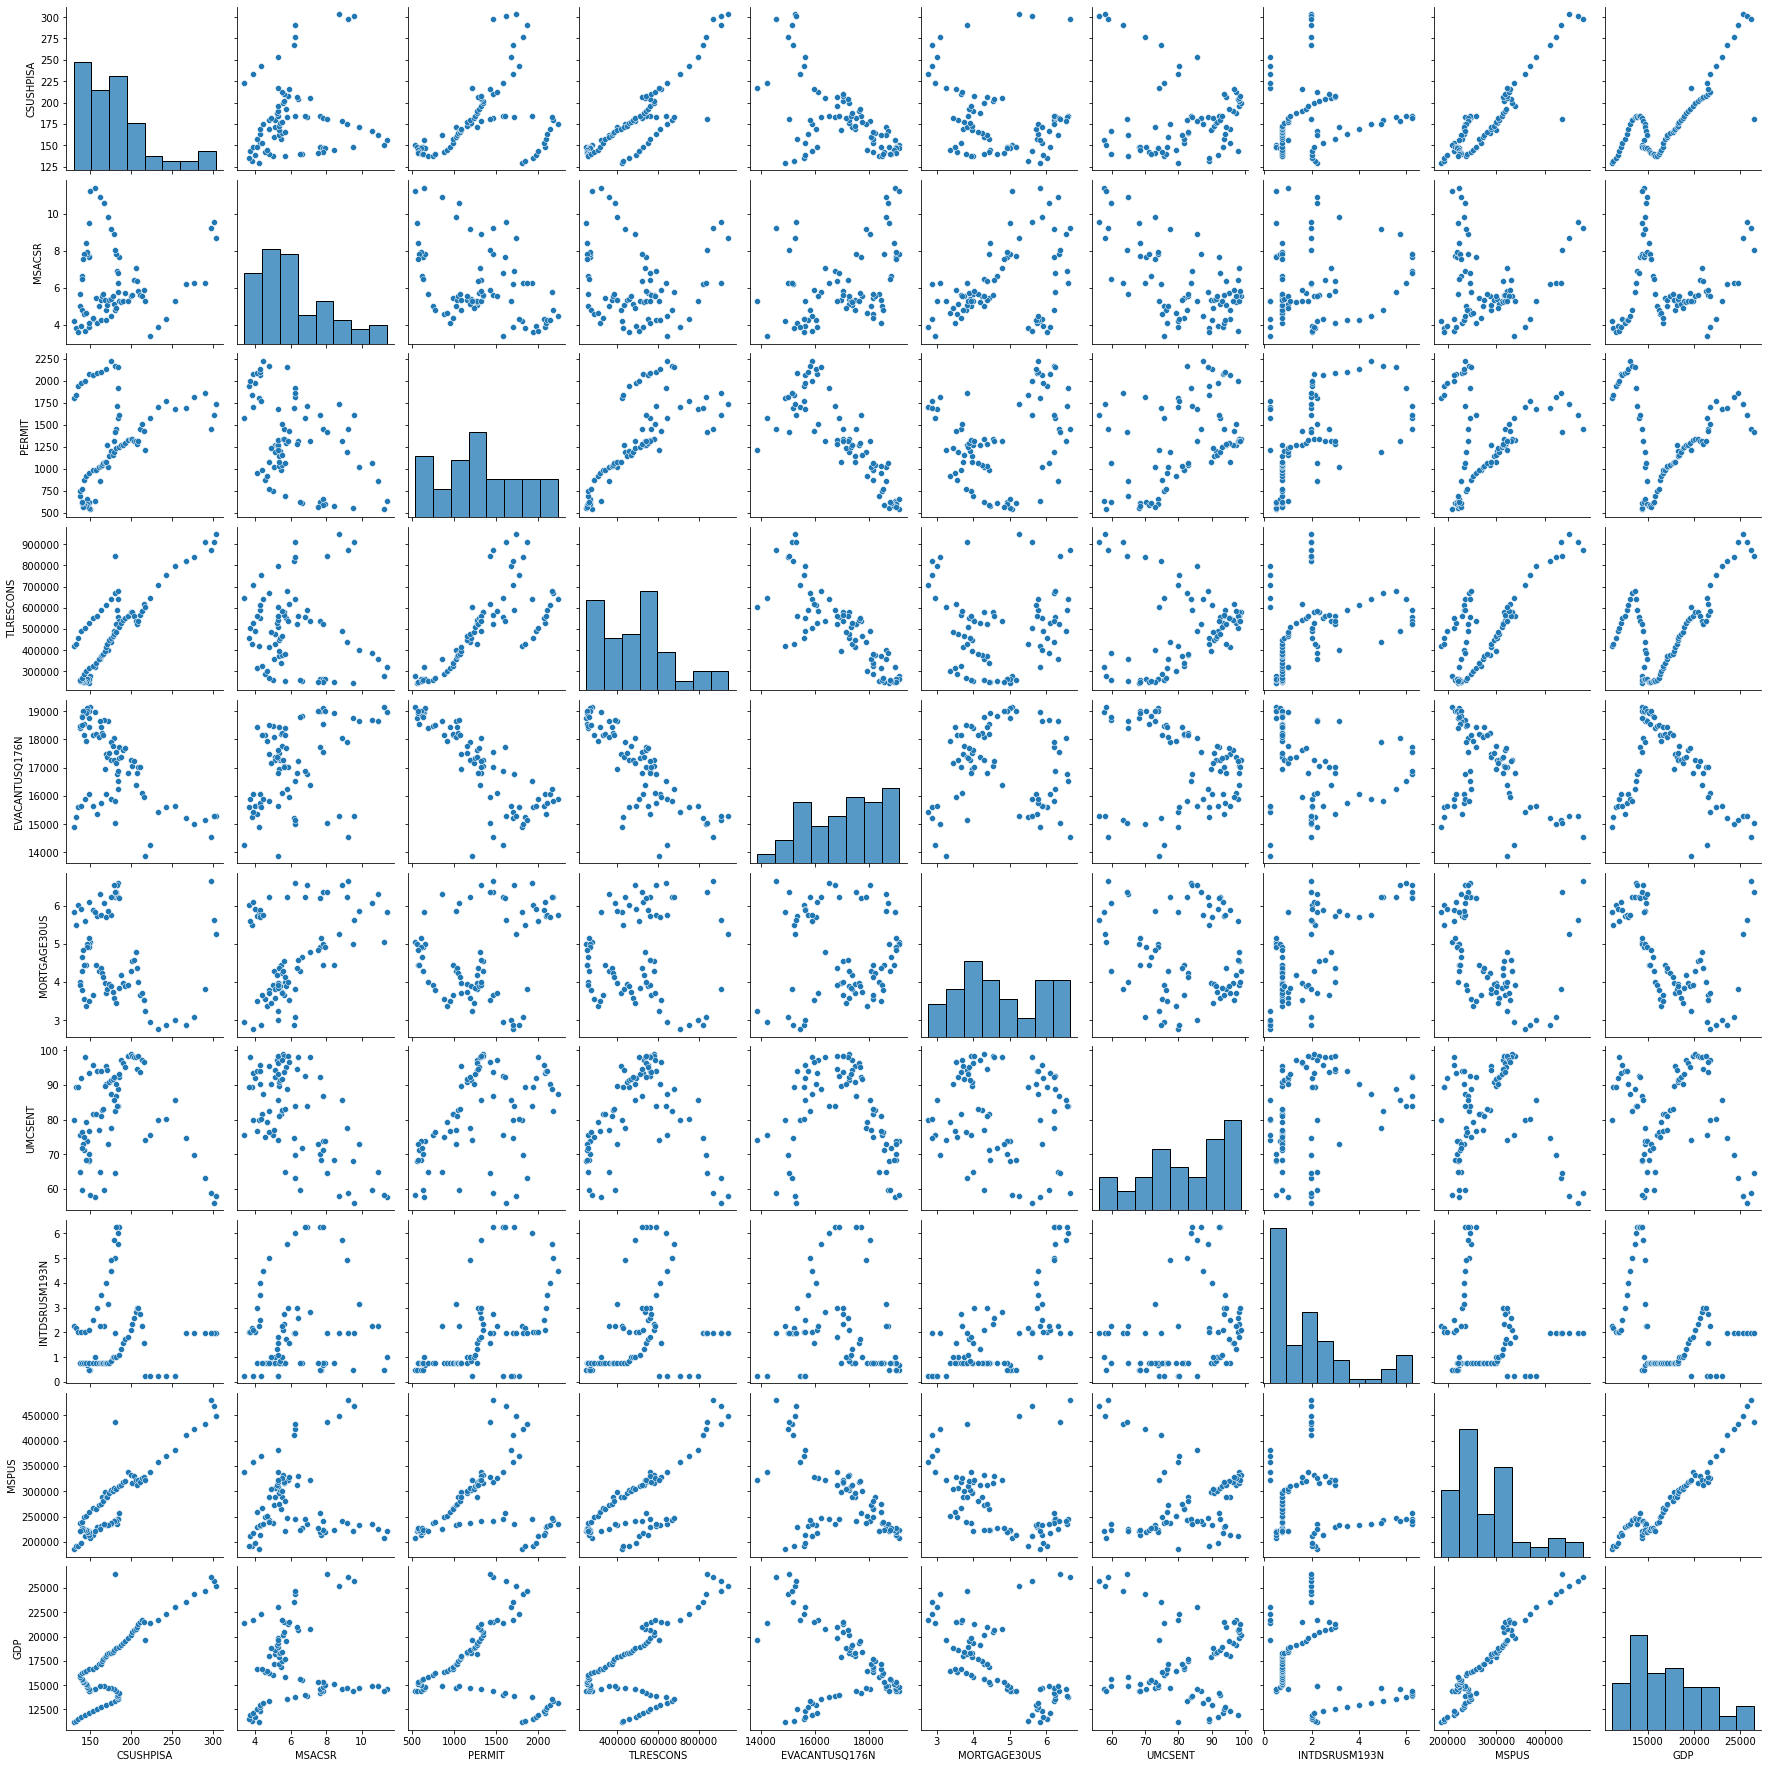

In [20]:
# Dataa exploration

sns.pairplot(merged_data)
plt.show()

From the plot above we can notice that there is linear relationship between (GDP,CSUSHPISA),(MSPUS,CSUSHPISA),(MSPUS,GDP) and some other variables

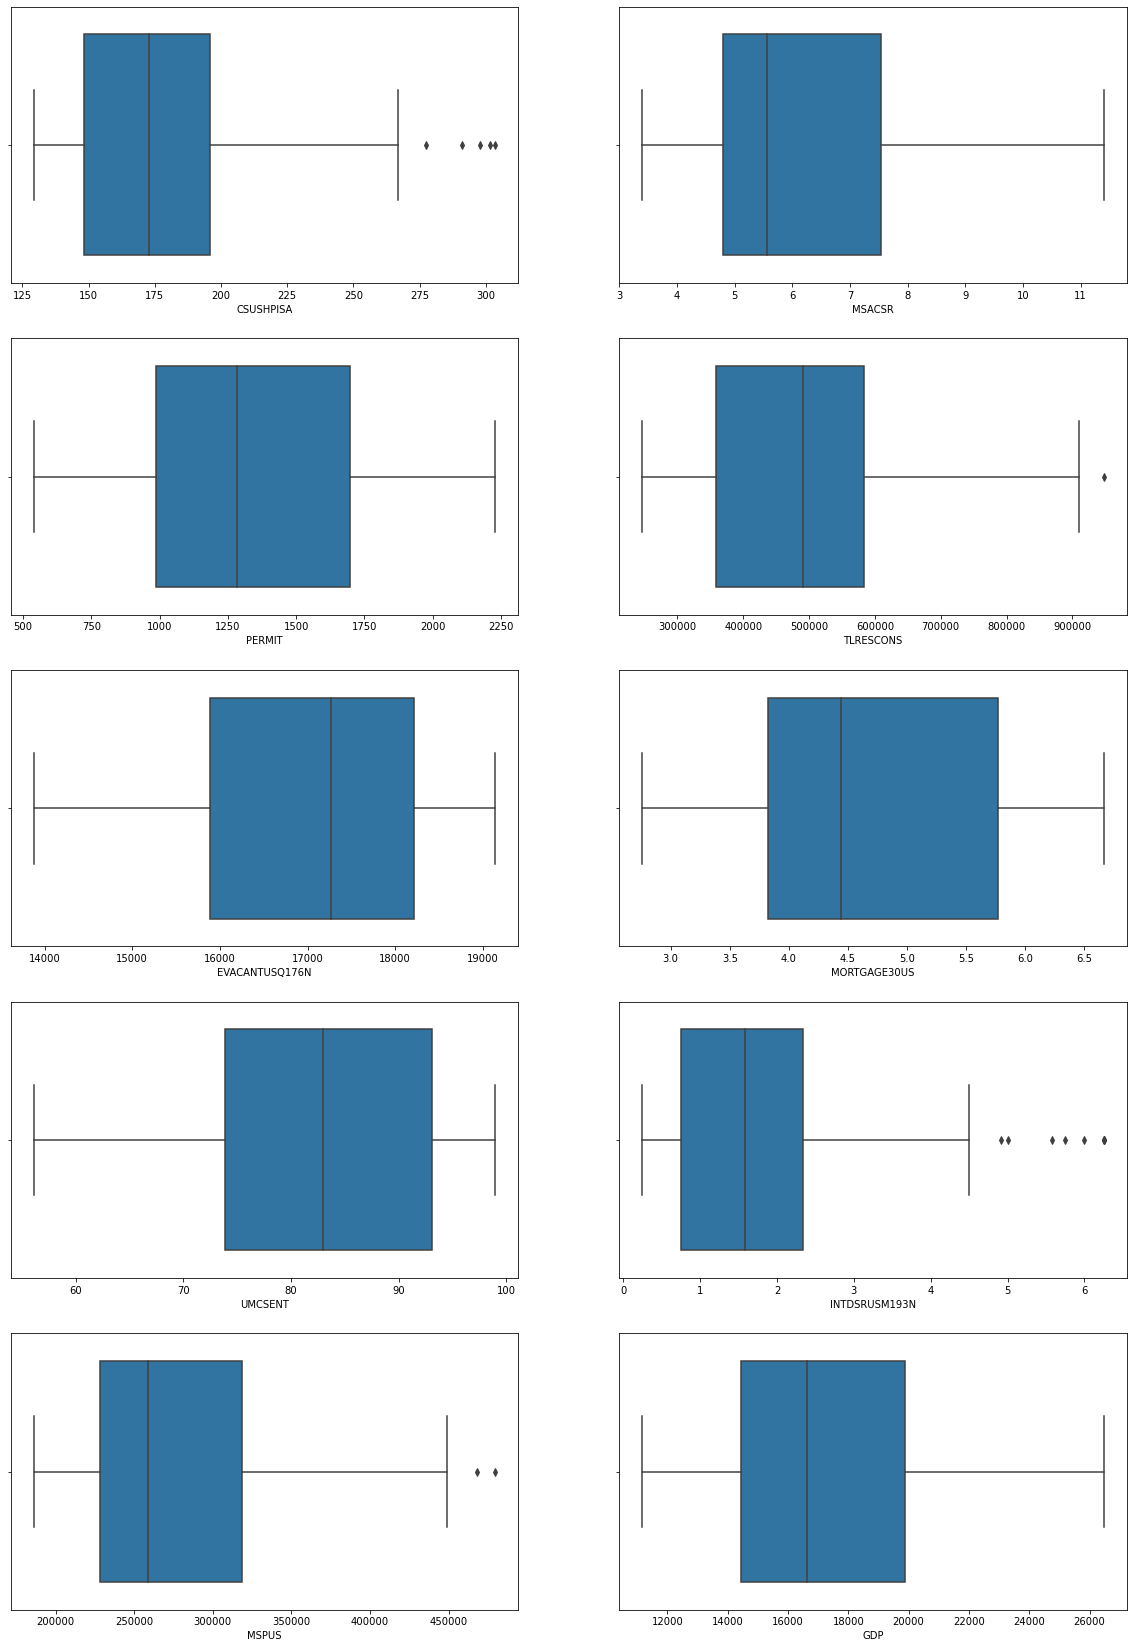

In [21]:
# Checking for outliers


cols = ['CSUSHPISA', 'MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N','MORTGAGE30US', 'UMCSENT', 'INTDSRUSM193N', 'MSPUS', 'GDP']
a= len(cols)
b=2
c=1

plt.figure(figsize=(20,60))
for i in cols:
    plt.subplot(a,b,c)
    sns.boxplot(merged_data[i])
    #plt.xticks(rotation=90)
    c += 1
    #plt.tight_layout()
plt.show()


Though it looks like we have few outliers in some variables, since we only have 81 rows of that and to keep the randomness of the data we are not treating outliers

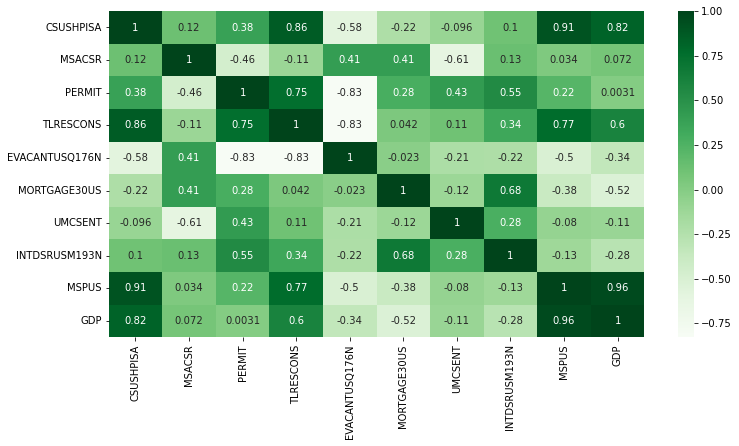

In [22]:
# Checking the correlation between the variables

plt.figure(figsize=(12,6))
sns.heatmap(merged_data.corr(),annot=True,cmap="Greens")
plt.show()

From the plot above we can understand that:

MSPUS (Median Sales Price of Houses Sold): There is a strong positive correlation (0.907924) relationship between the MSPUS and CSUSHPISA. Higher median sales prices are strongly associated with higher home prices.

TLRESCONS (Total Construction Spending: Residential): There is a strong positive correlation (0.861225) relationship between total construction spending on residential projects and CSUSHPISA. This suggests that higher construction spending is strongly associated with higher home prices.

GDP (Gross Domestic Product): There is a strong positive correlation (0.823877) relationship between GDP and CSUSHPISA. Higher GDP is strongly associated with higher home prices.

EVACANTUSQ176N (Housing Inventory Estimate: Vacant Housing Units): There is a moderate negative correlation (-0.584710) relationship between the estimated number of vacant housing units and CSUSHPISA. This indicates that a higher number of vacant housing units may exert downward pressure on home prices.

PERMIT (New Privately-Owned Housing Units Authorized): Positive : There is a moderate positive correlation (0.382217) relationship between the number of authorized housing units and CSUSHPISA. It indicates that a higher number of authorized housing units may have a positive influence on home prices.

All other variables 'MSACSR (Monthly Supply of New Houses)' , 'MORTGAGE30US (30-Year Fixed Rate Mortgage Average)','UMCSENT (University of Michigan: Consumer Sentiment)', 'INTDSRUSM193N (Interest Rates, Discount Rate)' have weak positive or negative correlation with CSUSHPISA.

#### Splitting the Data into Training and Testing Sets

In [23]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(merged_data, train_size = 0.8, test_size = 0.2, random_state = 100)

In [24]:
df_train.shape

(64, 11)

In [25]:
df_test.shape

(17, 11)

#### Rescaling the Features

In [26]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

cols = ['CSUSHPISA', 'MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'MORTGAGE30US', 'UMCSENT', 'INTDSRUSM193N', 'MSPUS', 'GDP']
df_train[cols] = scaler.fit_transform(df_train[cols])

#### Dividing into X and Y sets for the model building

In [27]:
y_train = df_train['CSUSHPISA'].copy()
X_train = df_train.drop(['CSUSHPISA','DATE'], 1)

y_test = df_test['CSUSHPISA'].copy()
X_test = df_test.drop(['CSUSHPISA','DATE'], 1)

#### GridsearchCv for parameter tuning for xgboost

In [28]:
parameters = {
    'n_estimators': [50, 100, 150, 200, 250],
    'learning_rate': [0.1, 0.05, 0.01, 0.02,1],
    'max_depth': [5, 8, 10, 12],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_test, y_test)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:46] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:49] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:50] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:53] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:31:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:56] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:31:57] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:02] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:05] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:06] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:09] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:19] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src

[18:32:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

[18:32:21] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "eval_set", "verbose" } are not used.

Best params: {'learning_rate': 1, 'max_depth': 5, 'n_estimators': 50, 'random_state': 42}
Best validation score = 0.7691309503192753


In [29]:
model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

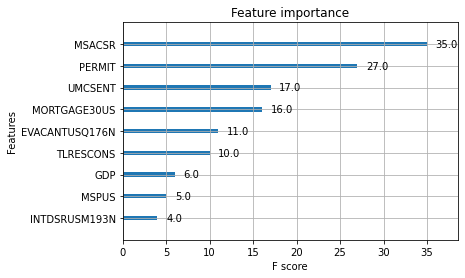

In [30]:
plot_importance(model);

#### Model evaluation

In [31]:
y_pred = model.predict(X_test)

print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

MAPE(y_test, y_pred)

mean_squared_error = 33266.61372151598


99.43843365749355

In [32]:
merged_data.to_excel("House_pricing_data.xlsx")